In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE

import pickle

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import load_model

In [3]:
NN = load_model('../lipika/NN_final_model.h5')

In [5]:
data_train = pd.read_csv("../lipika/cleaned_2013_14", low_memory = False);
data_test = pd.read_csv("../lipika/cleaned_2015", low_memory = False);
data_test = data_test.dropna()
data_train = data_test.dropna()

In [7]:
QDA_pred_test = pd.read_csv("../lipika/qda_preds_test", low_memory = False);
QDA_pred_train = pd.read_csv("../lipika/qda_preds_training", low_memory = False);

In [13]:
QDA_pred_test.describe()

,Unnamed: 0,pred,proba,true_val,int_rate,amnt,total_pymnt,term_adj,ROI,Real_ROI,annualized_amnt
count,346843.000000,346843.000000,346843.000000,346843.000000,346843.000000,346843.000000,346843.000000,346843.000000,346843.000000,346843.000000,346843.000000
mean,173422.842251,0.000747,0.000748,0.222738,0.125009,14663.481856,14929.412424,2.393037,0.124271,476.750707,12592.332271
std,100125.338735,0.027316,0.027305,0.416084,0.044357,8518.606655,9946.005835,1.237858,0.047128,2164.692245,34717.951795
min,0.000000,0.000000,0.000000,0.000000,0.053200,0.538397,0.000000,0.040000,-0.550012,-35000.000000,1.000000
25%,86712.500000,0.000000,0.000000,0.000000,0.091700,8000.000000,7214.910000,1.500000,0.091700,211.042190,3250.000000
50%,173423.000000,0.000000,0.000000,0.000000,0.122900,12600.000000,12416.440000,2.583333,0.122900,645.166821,5625.000000
75%,260133.500000,0.000000,0.000000,0.000000,0.154100,20000.000000,20638.640000,3.000000,0.154100,1361.816645,10576.209677
max,346844.000000,1.000000,1.000000,1.000000,0.538397,35000.000000,59265.976314,5.000000,0.289900,21506.599818,875000.000000


In [22]:
data_train.int_rate = data_train.int_rate/np.amax(data_train.int_rate)
data_train['model_term'] = data_train.term/np.amax(data_train.term)
data_train.dti = data_train.dti/np.amax(data_train.dti)
data_train.revol_util = data_train.revol_util/np.amax(data_train.revol_util)

data_test.int_rate = data_test.int_rate/np.amax(data_train.int_rate)
data_test['model_term'] = data_test.term/np.amax(data_train.term)
data_test.dti = data_test.dti/np.amax(data_test.dti)
data_test.revol_util = data_test.revol_util/np.amax(data_test.revol_util)

In [23]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt', 'term_adj', 'term', 'zip_code']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [68]:
def create_df(data_1, data_2, penal = 0.5):
    df = pd.DataFrame(data_1)
    df['proba'] = df.proba.map(lambda x: x[0])
    df['pred'] = df.pred.map(lambda x:x[0])
    
    df['int_rate'] = data_2['int_rate']
    df['amnt'] = data_2['amnt']
    df['total_pymnt'] = data_2['total_pymnt']
    df['term'] = data_2['term']
    df['ROI'] = (((1 + df['int_rate'])*(1-df['proba']))+(df['proba']*drr*penal))-1

    df['Real_ROI'] = df['amnt']*(((df['total_pymnt']/df['amnt'])**(1/df['term']))-1)
    df['annualized_amnt'] = df['amnt']*(1/df['term'])
    
    return df

In [69]:
distress = data_train[data_train.paid == 1]
drr = (np.sum(distress.total_pymnt)/np.sum(distress.amnt))**(1/np.mean(distress.term))
print(drr)

0.8672532737835931


In [36]:
NN_train_predictions = (NN.predict(x_train))
NN_test_predictions = (NN.predict(x_test))
NN_train_class = np.where(NN_train_predictions > 0.50, 1, 0)
NN_test_class = np.where(NN_test_predictions > 0.50, 1, 0)

In [70]:
train_data = {'proba' : NN_train_predictions.tolist(), 'pred' : NN_train_class.tolist(), 'true_val' : y_train}
test_data = {'proba' : NN_test_predictions.tolist(), 'pred' : NN_test_class.tolist(), 'true_val' : y_test}
df_train = create_df(train_data, data_train)
df_test =  create_df(test_data, data_test)

In [71]:
plt.plot(df_test[df_test.true_val == 1])

,proba,pred,true_val,int_rate,amnt,total_pymnt,term,ROI,Real_ROI,annualized_amnt
0,0.314888,0,0,0.239229,10000.0,11316.890190,3.0,-0.014446,420.991315,3333.333333
1,0.205924,0,0,0.139117,18000.0,19771.097253,3.0,-0.006161,571.996545,6000.000000
2,0.073871,0,0,0.098812,20000.0,21631.724329,3.0,0.049674,529.752342,6666.666667
3,0.525477,1,1,0.259845,17475.0,13449.650000,3.0,-0.174314,-1460.436080,5825.000000
4,0.661357,1,0,0.249630,21000.0,24473.227622,5.0,-0.290039,652.781115,4200.000000


/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


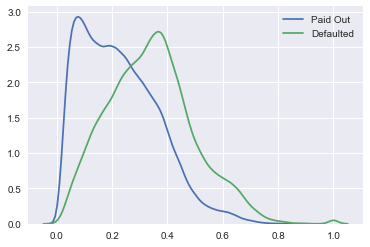

In [72]:
sns.kdeplot(df_test.loc[df_test.true_val == 0,'proba'], label = 'Paid Out');
sns.kdeplot(df_test.loc[df_test.true_val == 1,'proba'], label = 'Defaulted');

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


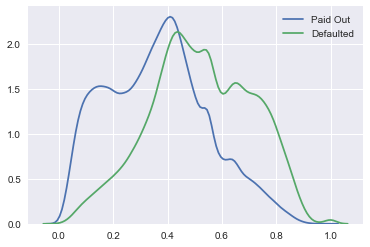

In [73]:
sns.kdeplot(df_train.loc[df_train.true_val == 0,'proba'], label = 'Paid Out');
sns.kdeplot(df_train.loc[df_train.true_val == 1,'proba'], label = 'Defaulted');

In [83]:
lims = np.linspace(0.05, 0.95, 19, endpoint = True)

for i in lims:
    score = roc_auc_score(np.where(NN_test_predictions > i, 1, 0), y_test)
    print(i, score)
    


0.05 0.5959068584537122
0.1 0.5980087514283862
0.15 0.5976610076091009
0.2 0.5997177370428228
0.25 0.6047853377950425
0.3 0.6119735132999691
0.35 0.6208204589818682
0.39999999999999997 0.6319990037025967
0.44999999999999996 0.6470553892262522
0.49999999999999994 0.6611412621720926
0.5499999999999999 0.6727342831255043
0.6 0.6846022570861161
0.65 0.7150760005559169
0.7 0.7423555698375598
0.75 0.7893189192098747
0.7999999999999999 0.8330397317033172
0.85 0.8710754334993399
0.9 0.8888161348571297
0.95 0.8888138917733933


In [85]:
roc_auc_score(np.where(NN_train_predictions > 0.999, 1, 0), y_train)

0.8888127702412304